In [1]:
from sympy.combinatorics import *
from sympy.interactive import init_printing #Enables more readable output of permutations.

from tqdm.notebook import tqdm # Progressbars of for-loops.

from math import factorial
import numpy as np

import pickle #File storing and reading

init_printing(perm_cyclic=True, pretty_print=False) #prints permutations in compact notation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from timeit import default_timer

from pympler.asizeof import asizeof

from sklearn.linear_model import LinearRegression

# Code base to allow computations in A(d)

In [3]:
def gen_ctype(l: dict,n: int):
    '''
    Input:
        l - cycle decompostion as a dictionary including 1 cycles. e.g. {1:2, 2:1} is a transposition in S_4
        n - specifies order of symmetric group
    Output:
        Generates all permutations of specified cycletype as a list
    '''
    
    has_to_be_partition = 0
    for key, value in l.items():
        has_to_be_partition = has_to_be_partition + key*value
    if has_to_be_partition < n:
        print("Invalid cycle type format.")
    else:
        list_with_cycle_type = []
        
        #run through all permutations and append them if they have the correct cycletype
        for i in list(symmetric(n)): 
            if i.cycle_structure == l:
                list_with_cycle_type.append(i)            
        return list_with_cycle_type
    
g2 = gen_ctype({1:2,2:1},4) #An example of all permutations with cycletype 2 (transpositions) in S_4
g2

[(2 3), (3)(1 2), (1 3), (3)(0 1), (3)(0 2), (0 3)]

In [4]:
def gen_all(d):
    ''' Input: non-negative interger
        Output: Dictionary of elements in the symmetric group with key being cycle type and value all permutations in S(d) with
        that cycle type.
    '''
    answer = {}
    
    for i in tqdm(symmetric(d), total = factorial(d)):
        C = ctype(i)
        if C in answer.keys():
            (answer[C]).append(i)
        else:
            answer[C] = [i]
    answer.pop((d,),None)
    return answer


In [5]:
def norm(p, cycle_dict = None):
    '''
    Input: permutation p, optionally the cycle structure of p.
    Output: The norm of p
    '''
    #If the cycle type of p is already computed we can reuse the result.
    if cycle_dict == None:
        cycle_dict = p.cycle_structure
    sum_of_lengths = 0
    num_cycles = 0
    
    #We use the formula N(sigma) = d-l if sigma has cyclestructure C_1C_2...C_l 
    for key, value in cycle_dict.items():
        sum_of_lengths += key*value
        num_cycles += value
    return sum_of_lengths-num_cycles

In [6]:
def norm2(p_tuple):
    #Computes norm from cyclestructure written as a tuple
    ans = 0
    for i,p in enumerate(p_tuple):
        ans += i*p
    return ans

In [7]:
def norm_check(p,q, norm_sum = None):
    '''
    Input: Permutations p and q, optionally the sum of their norms.
    Output: True if N(pq) = N(p) + N(q), otherwise False.
    '''
    if norm_sum == None:
        norm_sum = norm(p) + norm(q)
    p_trans = set(p.transpositions())
    q_trans = set(q.transpositions())
    
    if p_trans.intersection(q_trans) == set([]):
        return norm(p*q)==norm_sum
    return False

In [8]:
def Aprod(p_list, q_list, norm_sum = None):
    '''
    Input:
        - p_list and q_list, both lists of permutations corresponding to a conjugacy class in S_n
        - The sum of the norm of the conjugacy classes (optional)
    Output:
        - The product of the two conjugacy classes according to A(d)
    '''
    if norm_sum:
        return [s*t for s in p_list for t in q_list if norm_check(s,t,norm_sum)]
    return [s*t for s in p_list for t in q_list if norm_check(s,t)]

# Generate powers of g2, as 
g2_square = Aprod(g2,g2,2)
g2_cube = Aprod(g2,g2_square,3)
g2_square[0:5]

[(1 2 3), (1 3 2), (0 1)(2 3), (0 2 3), (0 3 2)]

In [9]:
def ctype(p):
    '''
    Input:
        Sympy permutation
    Output:
        Gives cycletype of permutation as a tuple with i'th coordinate being multiplicity of i-cycles.
    '''
    d = p.cycle_structure
    max_val = max(d.keys())
    L = []
    for i in range(1,max_val+1):
        if i in list(d.keys()):
            L.append(d[i])
        else:
            L.append(0)
    return tuple(L)

ctype(Permutation(3)(1,3)) # has 2 1-cycles (0 and 2) and one 2-cycle

(2, 1)

In [10]:
def decompose(plist: list, progressbar=True):
    '''
    Input: List of permutations
    Output: Decomposes list by occurences of cycletype
    '''
    cycle_count = {}
    for p in tqdm(plist, disable = progressbar):
        p_type = ctype(p)
        if p_type in list(cycle_count.keys()):
            cycle_count[p_type] += 1
        else:
            cycle_count[p_type] = 1
    return cycle_count
#Decomposes list of permutations into representatives of the conjugacy class, e.g. (g_2)^2 has 24 3-cycles and 6 2-cycles
print("g2 squared decomp", decompose(g2_square),
      "\n" "g2 cubed decomp", decompose(g2_cube))

g2 squared decomp {(1, 0, 1): 24, (0, 2): 6} 
g2 cubed decomp {(0, 0, 0, 1): 96}


In [11]:
def num_ctype(ctuple):
    '''
    Input: cycle type as a tuple
    Output: number of permutations with given cycle type using 
    '''
    n = sum((i+1)*ctuple[i] for i in range(len(ctuple)))
    numerator = factorial(n)
    denominator = 1
    for i in range(len(ctuple)):
        denominator *= ((i+1)**ctuple[i]) * factorial(ctuple[i])
    return numerator // denominator

num_ctype((2,1)) #Size of the conjugacy class of 2-cycles in d = 2*1+1*2 = 4

6

In [12]:
def to_string(d):
    # Takes cycletype from type dictionary to a string more humanly readable.
    if type(d) == dict:
        s = ""
        for key, value in d.items():
            s += str(value) + "*" + "g_"+ to_string(key) + "  +  "
        return s[0:-3]
    s = ""
    for i,k in enumerate(d):
        if i!=0 and k!= 0:
            s+= str(i+1) + "^" + str(k) + ","
    return s[0:-1]

In [13]:
def decompose2(plist, string_output = False):
    '''
    Input: list of permutations
    Output: decomposition according to A(d)
    '''
    d = decompose(plist)
    for i in d.keys():
        d[i] //= num_ctype(i)
        
    if string_output:
        return to_string(d)
    return d
#Same as decompose, but divided by the size of the conjugacy class, so (g_2)^2 = 3g_3+2g_{2^2}. This recovers the results from
#project catalgoue
print("g2 square", decompose2(g2_square), 
      "\n" "g2 cube", decompose2(g2_cube))

g2 square {(1, 0, 1): 3, (0, 2): 2} 
g2 cube {(0, 0, 0, 1): 16}


# Measuring computations in  A(d)

In [14]:
d=6
basis = gen_all(d)

In [15]:
#Multiplication table for generators
generators = [((d-2*i,i),basis[(d-2*i,i)]) for i in range(1,d//2+1)]
max_mem = 0
time = 0


for k1,v1 in tqdm(generators):
    for k2,v2 in basis.items():
        n = norm2(k1) + norm2(k2)
        if n < d:
            s = "g_"+to_string(k1) + " * g_" + to_string(k2)
            
            #Measure time of multiplication
            start = default_timer()
            prod = Aprod(v1,v2,n)
            s += " = " + decompose2(prod, string_output = True)
            end = default_timer()
            time += end-start
            
            #Measure memory product
            mem = asizeof(prod)
            if mem > max_mem:
                max_mem = mem
                print(s)
print("Time:", time, "," , "most memory (bytes):", max_mem)

g_2^1 * g_2^1 = 3*g_3^1  +  2*g_2^2  
g_2^1 * g_3^1 = 4*g_4^1  +  1*g_2^1,3^1  
g_2^1 * g_2^2 = 2*g_4^1  +  3*g_2^1,3^1  +  3*g_2^3  
g_2^1 * g_4^1 = 5*g_5^1  +  1*g_2^1,4^1  
g_2^1 * g_2^1,3^1 = 5*g_5^1  +  4*g_2^1,4^1  +  6*g_3^2  
g_2^2 * g_2^2 = 5*g_5^1  +  4*g_2^1,4^1  +  9*g_3^2  
g_2^2 * g_2^1,3^1 = 18*g_6^1  

Time: 5.511144258998684 , most memory (bytes): 1540080


### Predicting time for A(10)

In [16]:
d_vals = list(range(5,10))
runtimes = [0.25, 3.59, 71, 1604, 14*3600]
memory = [111560,1540080, 22422344, 223715480, 2415002808]

df = pd.DataFrame(data = {"d": d_vals, "Runtime":runtimes,
                          "log(Runtime)":np.log(runtimes),
                          "log(Memory)":np.log(memory)})

In [17]:
x = np.array(d_vals).reshape((-1,1))
59
model1 = LinearRegression().fit(x, np.log(runtimes))
model2 = LinearRegression().fit(x, np.log(memory))

print("Predictions for d = 10 and d = 11")
print("Time (hours):", np.exp(model1.predict([[10],[11]])) / 3600, "\n",
      "Memory (GB):", np.exp(model2.predict([[10],[11]])) / (2**30))

Predictions for d = 10 and d = 11
Time (hours): [ 231.1055269  4894.62505387] 
 Memory (GB): [ 30.38510435 368.09323387]


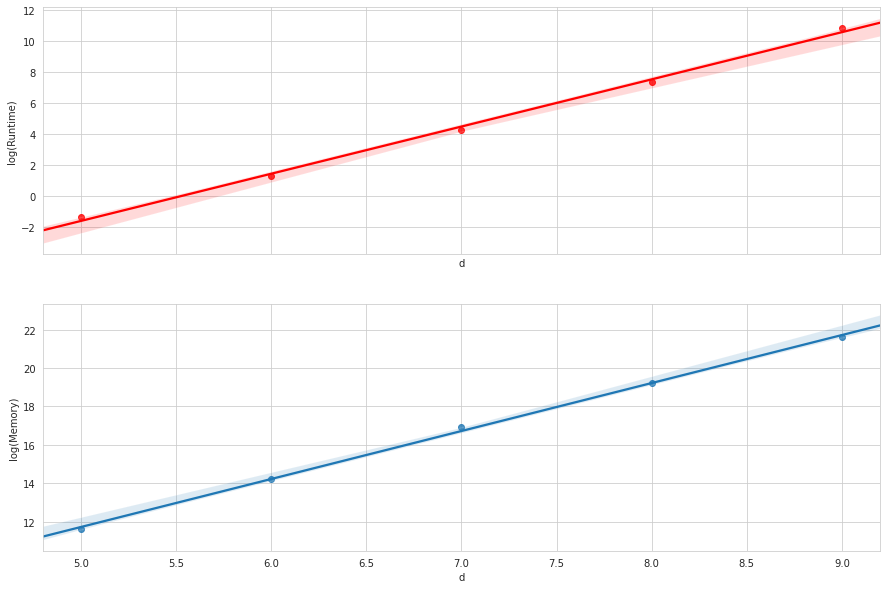

In [18]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex=True, figsize=(15,10))
sns_plot = sns.regplot(x="d",y="log(Runtime)",data=df,
                       truncate = False,
                       color='red', ax = ax1)

sns_plot = sns.regplot(x="d",y="log(Memory)",data=df,
                       truncate = False, ax=ax2)
plt.show()